# Exploración inicial del Sleep-EDFx
En esta notebook vamos a inspeccionar el manifiesto de sesiones, revisar estadísticas descriptivas básicas y visualizar segmentos de distintos estadios de sueño para algunos sujetos.

In [8]:
# Configuración inicial
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mne

sns.set_theme(style="whitegrid", palette="deep")
PROJECT_ROOT = Path("..").resolve()
DATA_ROOT = PROJECT_ROOT / "data"
MANIFEST_PATH = DATA_ROOT / "processed" / "manifest.csv"
MANIFEST_PATH

PosixPath('/Users/ignacio/Repos/Sleep/data/processed/manifest.csv')

In [9]:
if not MANIFEST_PATH.exists():
    raise FileNotFoundError(
        "No se encontró el manifest. Ejecutá src/manifest.py antes de continuar."
    )

manifest = pd.read_csv(MANIFEST_PATH)
manifest.head()

,subject_id,subset,version,psg_path,hypnogram_path,status
0,SC4201E,sleep-cassette,1.0.0,data/raw/physionet.org/files/sleep-edfx/1.0.0/...,data/raw/physionet.org/files/sleep-edfx/1.0.0/...,ok
1,SC4141E,sleep-cassette,1.0.0,data/raw/physionet.org/files/sleep-edfx/1.0.0/...,data/raw/physionet.org/files/sleep-edfx/1.0.0/...,ok
2,SC4171E,sleep-cassette,1.0.0,data/raw/physionet.org/files/sleep-edfx/1.0.0/...,data/raw/physionet.org/files/sleep-edfx/1.0.0/...,ok
3,SC4272F,sleep-cassette,1.0.0,data/raw/physionet.org/files/sleep-edfx/1.0.0/...,data/raw/physionet.org/files/sleep-edfx/1.0.0/...,ok
4,SC4041E,sleep-cassette,1.0.0,data/raw/physionet.org/files/sleep-edfx/1.0.0/...,data/raw/physionet.org/files/sleep-edfx/1.0.0/...,ok


## 1. Resumen del manifiesto
El manifiesto enumera las sesiones disponibles junto con el estado de cada par PSG/Hipnograma. Revisemos cantidades básicas y la distribución por subset/version.

In [3]:
manifest.describe(include="all")

,subject_id,subset,version,psg_path,hypnogram_path,status
count,74,74,74,74,73,74
unique,74,1,1,74,73,2
top,SC4201E,sleep-cassette,1.0.0,data/raw/physionet.org/files/sleep-edfx/1.0.0/...,data/raw/physionet.org/files/sleep-edfx/1.0.0/...,ok
freq,1,74,74,1,1,73


In [10]:
status_counts = (
    manifest["status"].value_counts().rename_axis("status").reset_index(name="sessions")
)
subset_counts = (
    manifest.groupby(["subset", "status"]).size().reset_index(name="sessions")
)
version_counts = (
    manifest.groupby(["version", "status"]).size().reset_index(name="sessions")
)

status_counts, subset_counts, version_counts

(              status  sessions
 0                 ok        73
 1  missing_hypnogram         1,
            subset             status  sessions
 0  sleep-cassette  missing_hypnogram         1
 1  sleep-cassette                 ok        73,
   version             status  sessions
 0   1.0.0  missing_hypnogram         1
 1   1.0.0                 ok        73)

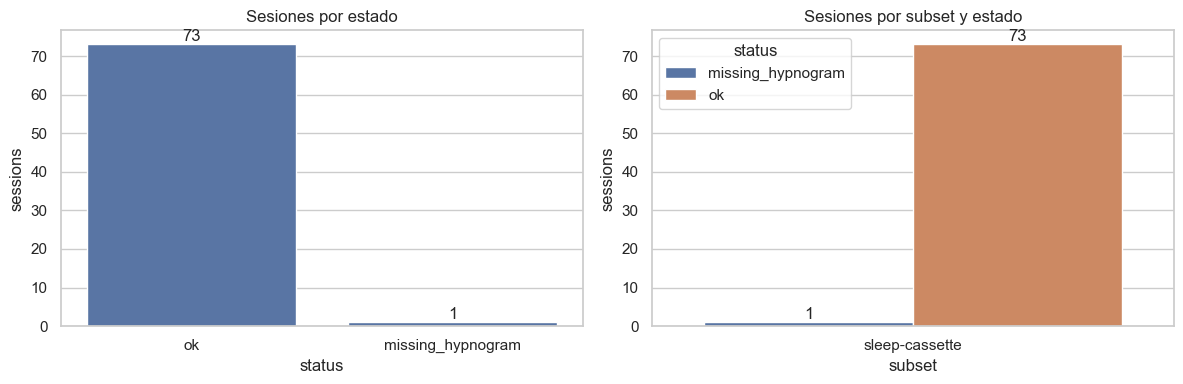

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.barplot(data=status_counts, x="status", y="sessions", ax=axes[0])
axes[0].set_title("Sesiones por estado")
axes[0].bar_label(axes[0].containers[0])
sns.barplot(data=subset_counts, x="subset", y="sessions", hue="status", ax=axes[1])
axes[1].set_title("Sesiones por subset y estado")
axes[1].bar_label(axes[1].containers[0])
axes[1].bar_label(axes[1].containers[1])
axes[1].legend(title="status")
plt.tight_layout()

## 2. Distribución de estadios a partir del hipnograma
Para las sesiones con hipnograma disponible (`status == 'ok'`) podemos estimar la duración relativa de cada estadio de sueño leyendo las anotaciones.

In [6]:
STAGE_LABELS = [
    "Sleep stage W",
    "Sleep stage 1",
    "Sleep stage 2",
    "Sleep stage 3",
    "Sleep stage 4",
    "Sleep stage R",
]
STAGE_CANONICAL = {
    "Sleep stage W": "W",
    "Sleep stage 1": "N1",
    "Sleep stage 2": "N2",
    "Sleep stage 3": "N3",
    "Sleep stage 4": "N3",
    "Sleep stage R": "REM",
}


def compute_stage_durations(hypnogram_path: str) -> pd.DataFrame:
    annotations = mne.read_annotations(hypnogram_path)
    rows = []
    for desc, duration in zip(annotations.description, annotations.duration):
        if desc in STAGE_CANONICAL:
            rows.append((STAGE_CANONICAL[desc], duration))
    if not rows:
        return pd.DataFrame(columns=["stage", "duration_sec"])
    df = pd.DataFrame(rows, columns=["stage", "duration_sec"])
    return df.groupby("stage", as_index=False)["duration_sec"].sum()

In [12]:
stage_summaries = []
missing_hypnograms = []
for row in manifest[manifest["status"] == "ok"].itertuples():
    hypnogram_path = Path(row.hypnogram_path)
    if not hypnogram_path.is_absolute():
        hypnogram_path = PROJECT_ROOT / hypnogram_path
    if hypnogram_path.exists():
        df = compute_stage_durations(hypnogram_path)
        if not df.empty:
            df["subject_id"] = row.subject_id
            stage_summaries.append(df)
    else:
        missing_hypnograms.append(row.subject_id)
if missing_hypnograms:
    print(
        f"No se encontraron {len(missing_hypnograms)} hipnogramas: {missing_hypnograms}"
    )
if not stage_summaries:
    raise RuntimeError("No se encontraron hipnogramas para calcular estadísticas.")
stages_all = pd.concat(stage_summaries, ignore_index=True)
stages_all.head()

,stage,duration_sec,subject_id
0,N1,1170.0,SC4201E
1,N2,16170.0,SC4201E
2,N3,120.0,SC4201E
3,REM,5310.0,SC4201E
4,W,61320.0,SC4201E


In [13]:
stage_totals = stages_all.groupby("stage", as_index=False)["duration_sec"].sum()
stage_totals["hours"] = stage_totals["duration_sec"] / 3600
stage_totals["percent"] = (
    100 * stage_totals["duration_sec"] / stage_totals["duration_sec"].sum()
)
stage_totals.sort_values("duration_sec", ascending=False)

,stage,duration_sec,hours,percent
4,W,4116420.0,1143.450000,68.900516
1,N2,1009020.0,280.283333,16.888947
3,REM,400980.0,111.383333,6.711591
2,N3,236400.0,65.666667,3.956856
0,N1,211620.0,58.783333,3.542089


/var/folders/6c/1g3b2t8s1l5ch_c9nch8gppw0000gn/T/ipykernel_75734/2508933665.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=stage_totals.sort_values('percent', ascending=False), x='percent', y='stage', palette='mako')


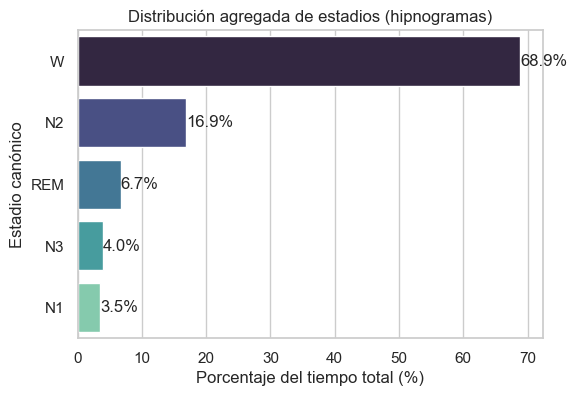

In [14]:
plt.figure(figsize=(6, 4))
sns.barplot(
    data=stage_totals.sort_values("percent", ascending=False),
    x="percent",
    y="stage",
    palette="mako",
)
plt.xlabel("Porcentaje del tiempo total (%)")
plt.ylabel("Estadio canónico")
plt.title("Distribución agregada de estadios (hipnogramas)")
for container in plt.gca().containers:
    plt.bar_label(container, fmt="%.1f%%")
plt.show()

In [15]:
subject_stage_share = stages_all.copy()
subject_stage_share["total_subject"] = subject_stage_share.groupby("subject_id")[
    "duration_sec"
].transform("sum")
subject_stage_share["percent"] = (
    100 * subject_stage_share["duration_sec"] / subject_stage_share["total_subject"]
)
subject_stage_share.head()

,stage,duration_sec,subject_id,total_subject,percent
0,N1,1170.0,SC4201E,84090.0,1.391366
1,N2,16170.0,SC4201E,84090.0,19.229397
2,N3,120.0,SC4201E,84090.0,0.142704
3,REM,5310.0,SC4201E,84090.0,6.314663
4,W,61320.0,SC4201E,84090.0,72.921869


/var/folders/6c/1g3b2t8s1l5ch_c9nch8gppw0000gn/T/ipykernel_75734/1311234654.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subject_stage_share, x='stage', y='percent', palette='Set2')


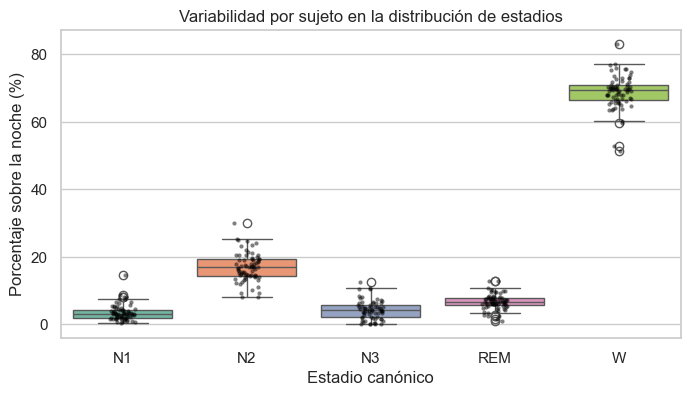

In [16]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=subject_stage_share, x="stage", y="percent", palette="Set2")
sns.stripplot(
    data=subject_stage_share, x="stage", y="percent", color="black", alpha=0.5, size=3
)
plt.ylabel("Porcentaje sobre la noche (%)")
plt.xlabel("Estadio canónico")
plt.title("Variabilidad por sujeto en la distribución de estadios")
plt.show()

## 3. Ejemplos de señales por estadio
Vamos a elegir algunos sujetos y recortar segmentos representativos de diferentes estadios (vigilia, N2, N3 y REM).

In [20]:
DEFAULT_CHANNELS = ["EEG Fpz-Cz", "EEG Pz-Oz", "EOG horizontal", "EMG submental"]


def get_session_paths(subject_id: str) -> tuple[Path, Path]:
    match = manifest[
        (manifest["subject_id"] == subject_id) & (manifest["status"] == "ok")
    ]
    if match.empty:
        raise ValueError(f"No hay sesión 'ok' para el sujeto {subject_id}")
    row = match.iloc[0]
    psg_path = Path(row.psg_path)
    hypnogram_path = Path(row.hypnogram_path)
    if not psg_path.is_absolute():
        psg_path = PROJECT_ROOT / psg_path
    if not hypnogram_path.is_absolute():
        hypnogram_path = PROJECT_ROOT / hypnogram_path
    return psg_path, hypnogram_path


def merge_stage_regions(hypnogram_path: Path | str, stage: str):
    hypnogram_path = Path(hypnogram_path)
    annotations = mne.read_annotations(hypnogram_path)
    regions = []
    current_start = None
    current_end = None
    for onset, duration, desc in zip(
        annotations.onset, annotations.duration, annotations.description
    ):
        canonical = STAGE_CANONICAL.get(desc)
        if canonical == stage:
            if current_start is None:
                current_start = onset
                current_end = onset + duration
            else:
                current_end = onset + duration
        else:
            if current_start is not None:
                regions.append((current_start, current_end))
                current_start = None
                current_end = None
    if current_start is not None:
        regions.append((current_start, current_end))
    return regions


def find_stage_window(hypnogram_path: Path | str, stage: str, duration: float = 120.0):
    regions = merge_stage_regions(hypnogram_path, stage)
    if not regions:
        return None
    regions.sort(key=lambda r: r[1] - r[0], reverse=True)
    longest_start, longest_end = regions[0]
    window_duration = longest_end - longest_start
    if window_duration <= 0:
        return None
    if window_duration >= duration:
        return longest_start, longest_start + duration
    return longest_start, longest_end


def extract_segment(
    psg_path: Path | str,
    start: float,
    end: float,
    picks=None,
    resample: float | None = 100.0,
):
    psg_path = Path(psg_path)
    raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
    available = raw.ch_names
    if picks is None:
        picks = [ch for ch in DEFAULT_CHANNELS if ch in available] or available
    raw.pick_channels(picks)
    if resample:
        raw.resample(resample)
    segment = raw.copy().crop(tmin=start, tmax=end)
    data = segment.get_data()
    times = segment.times
    return times, data, segment.ch_names


def plot_segment(
    subject_id: str, stage: str, duration: float = 120.0, resample: float | None = 100.0
):
    psg_path, hypnogram_path = get_session_paths(subject_id)
    if not hypnogram_path.exists():
        raise FileNotFoundError(
            f"No hay hipnograma para {subject_id} ({hypnogram_path})"
        )
    if not psg_path.exists():
        raise FileNotFoundError(f"No hay PSG para {subject_id} ({psg_path})")
    window = find_stage_window(hypnogram_path, stage, duration)
    if window is None:
        raise RuntimeError(
            f"No se encontró una ventana de {duration}s en estadio {stage} para {subject_id}"
        )
    start, end = window
    times, data, channels = extract_segment(psg_path, start, end, resample=resample)
    fig, axes = plt.subplots(
        len(channels), 1, figsize=(14, 2.0 * len(channels)), sharex=True
    )
    if len(channels) == 1:
        axes = [axes]
    for idx, ax in enumerate(axes):
        ax.plot(times, data[idx])
        ax.set_ylabel(channels[idx])
        ax.grid(True, linestyle="--", alpha=0.3)
    axes[-1].set_xlabel("Tiempo (s)")
    fig.suptitle(
        f"{subject_id} | Estadio {stage} | {duration:.0f}s desde t={start:.1f}s"
    )
    fig.tight_layout(rect=(0, 0, 1, 0.96))
    return fig

In [21]:
stage_targets = ["W", "N2", "N3", "REM"]
subjects_available = list(subject_stage_share["subject_id"].unique())
if not subjects_available:
    raise RuntimeError("No hay sujetos con hipnograma disponible para los ejemplos.")
example_plan = [
    (subjects_available[idx % len(subjects_available)], stage)
    for idx, stage in enumerate(stage_targets)
]
example_plan

[('SC4201E', 'W'), ('SC4141E', 'N2'), ('SC4171E', 'N3'), ('SC4272F', 'REM')]

/var/folders/6c/1g3b2t8s1l5ch_c9nch8gppw0000gn/T/ipykernel_75734/1334737956.py:54: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/var/folders/6c/1g3b2t8s1l5ch_c9nch8gppw0000gn/T/ipykernel_75734/1334737956.py:54: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/var/folders/6c/1g3b2t8s1l5ch_c9nch8gppw0000gn/T/ipykernel_75734/1334737956.py:54: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Sampling frequency of the instance is already 100.0, returning unmodified.


/var/folders/6c/1g3b2t8s1l5ch_c9nch8gppw0000gn/T/ipykernel_75734/1334737956.py:54: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/var/folders/6c/1g3b2t8s1l5ch_c9nch8gppw0000gn/T/ipykernel_75734/1334737956.py:54: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/var/folders/6c/1g3b2t8s1l5ch_c9nch8gppw0000gn/T/ipykernel_75734/1334737956.py:54: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/var/folders/6c/1g3b2t8s1l5ch_c9nch8gppw0000gn/T/ipykernel_75734/1334737956.py:54: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting val

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Sampling frequency of the instance is already 100.0, returning unmodified.


/var/folders/6c/1g3b2t8s1l5ch_c9nch8gppw0000gn/T/ipykernel_75734/1334737956.py:54: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/var/folders/6c/1g3b2t8s1l5ch_c9nch8gppw0000gn/T/ipykernel_75734/1334737956.py:54: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/var/folders/6c/1g3b2t8s1l5ch_c9nch8gppw0000gn/T/ipykernel_75734/1334737956.py:54: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Sampling frequency of the instance is already 100.0, returning unmodified.


/var/folders/6c/1g3b2t8s1l5ch_c9nch8gppw0000gn/T/ipykernel_75734/1334737956.py:54: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/var/folders/6c/1g3b2t8s1l5ch_c9nch8gppw0000gn/T/ipykernel_75734/1334737956.py:54: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/var/folders/6c/1g3b2t8s1l5ch_c9nch8gppw0000gn/T/ipykernel_75734/1334737956.py:54: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/var/folders/6c/1g3b2t8s1l5ch_c9nch8gppw0000gn/T/ipykernel_75734/1334737956.py:54: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting val

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Sampling frequency of the instance is already 100.0, returning unmodified.


[('SC4201E', 'W', <Figure size 1400x800 with 4 Axes>),
 ('SC4141E', 'N2', <Figure size 1400x800 with 4 Axes>),
 ('SC4171E', 'N3', <Figure size 1400x800 with 4 Axes>),
 ('SC4272F', 'REM', <Figure size 1400x800 with 4 Axes>)]

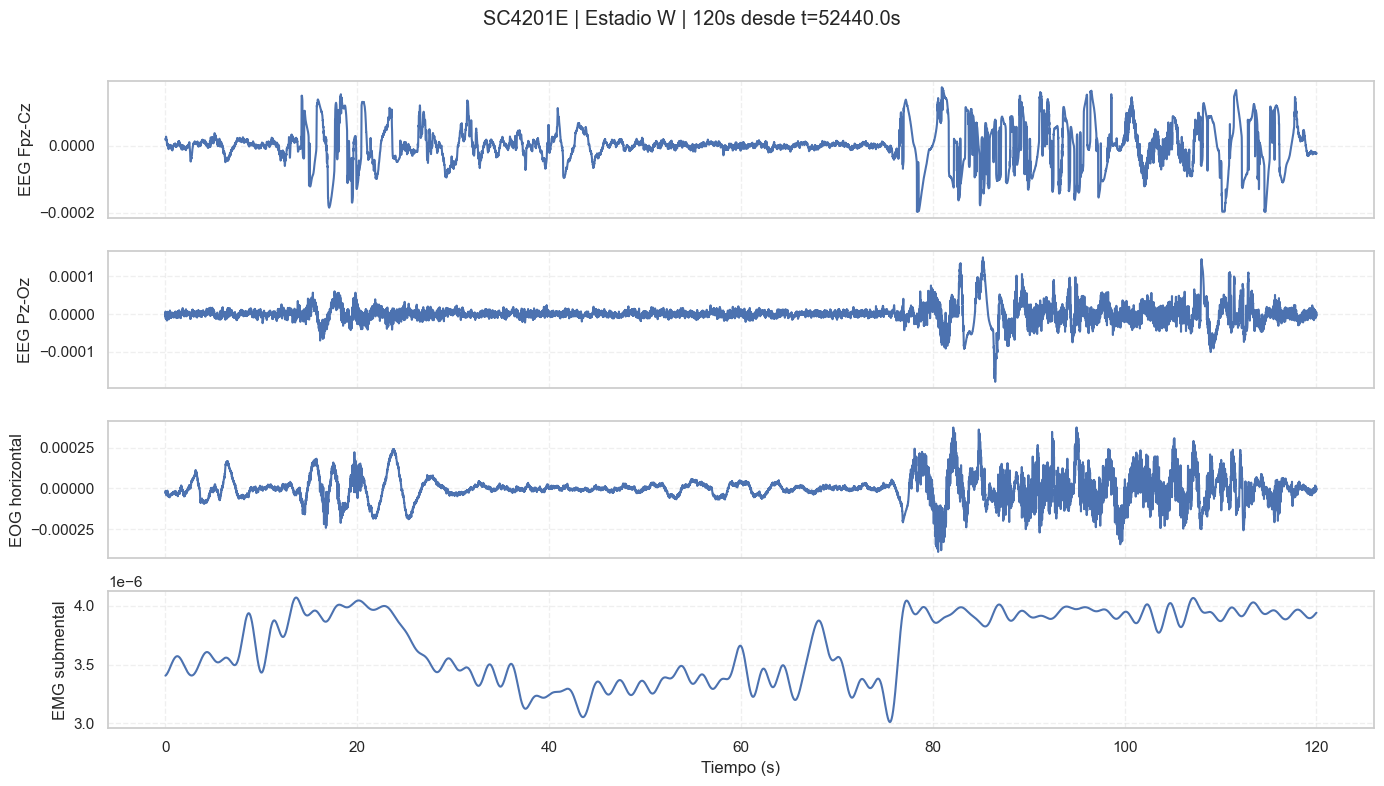

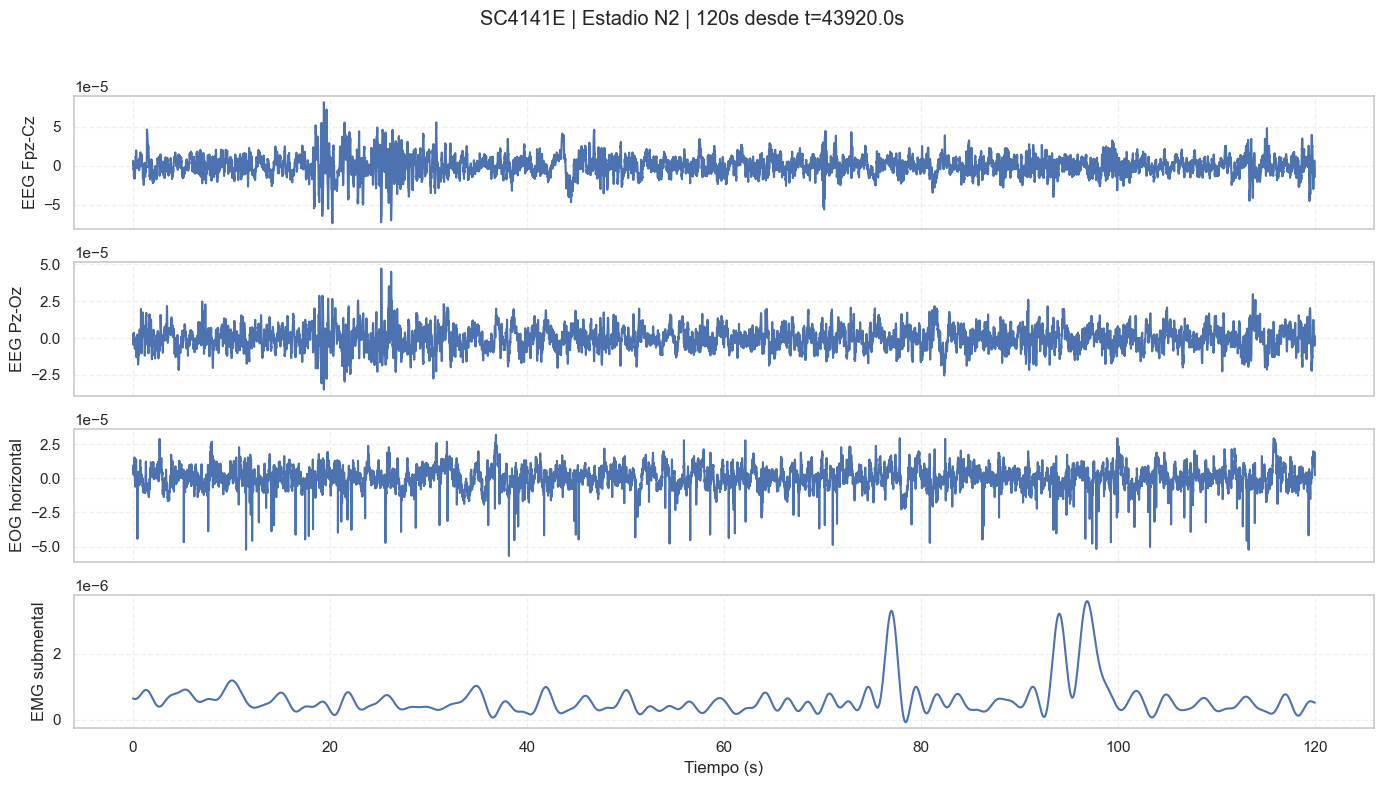

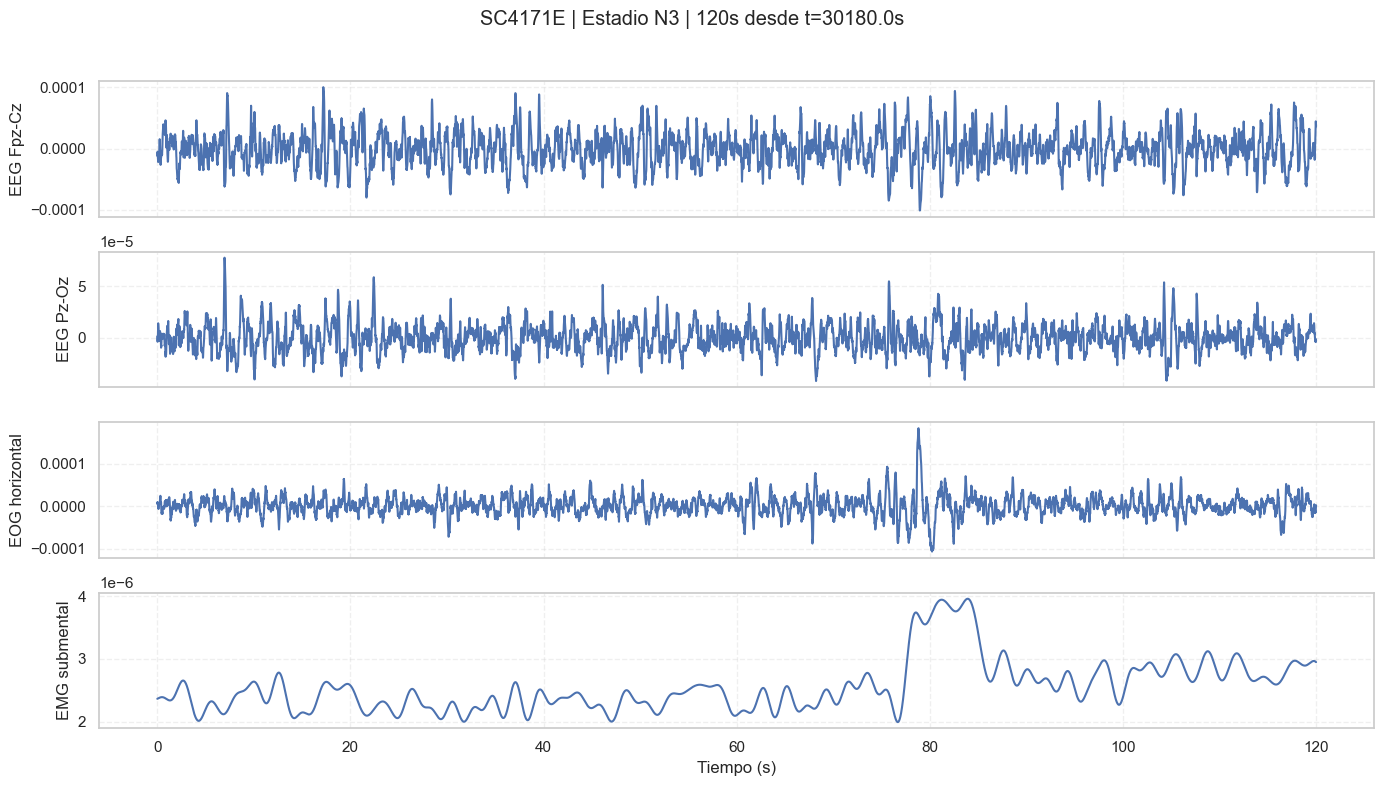

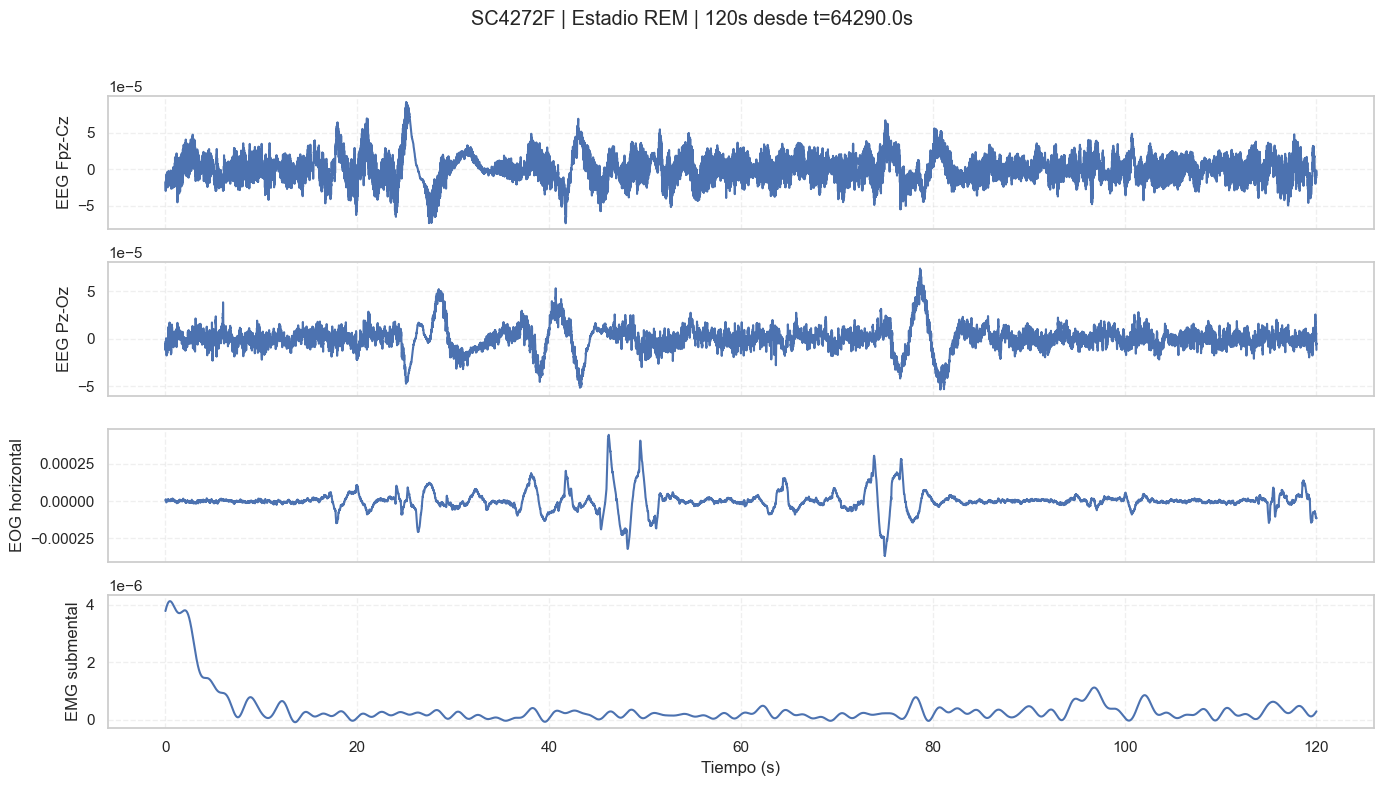

In [22]:
figures = []
for subject_id, stage in example_plan:
    try:
        fig = plot_segment(subject_id, stage, duration=120.0)
        figures.append((subject_id, stage, fig))
    except Exception as exc:
        print(f"No se pudo generar segmento para {subject_id} - {stage}: {exc}")
figures